In [1]:
from scipy.spatial.distance import cdist
from scipy.ndimage import affine_transform

import skimage.feature as skfeature
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import warnings
warnings.filterwarnings('ignore')

In [2]:
ll = cv2.imread("/home/taylor/fun/ml/courses/Solutions-Stanford-cs131-cv/hw3_release/sudoku.png", cv2.IMREAD_GRAYSCALE)
ll.shape

(563, 558)

In [3]:
file1 = "marrakech1.jpg"
file2 = "marrakech2.jpg"

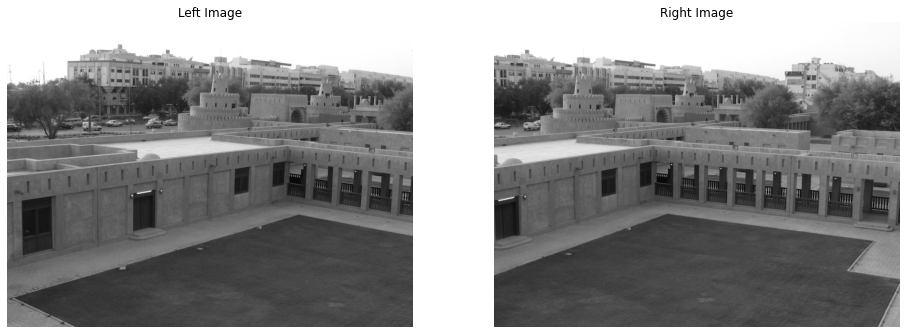

In [4]:
left_img = cv2.imread("sample_images/" + file1, cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread("sample_images/" + file2, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(16, 12))
plt.subplot(121)
plt.title("Left Image")
plt.imshow(left_img, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title("Right Image")
plt.imshow(right_img, cmap='gray')
plt.axis('off');

# Harris Corner

In [5]:
# patch size provided here, so we can remove the border pixels in the corner peaks method
PATCH_SIZE = 32

Left Image keypoints: 600, Right Image keypoints: 600


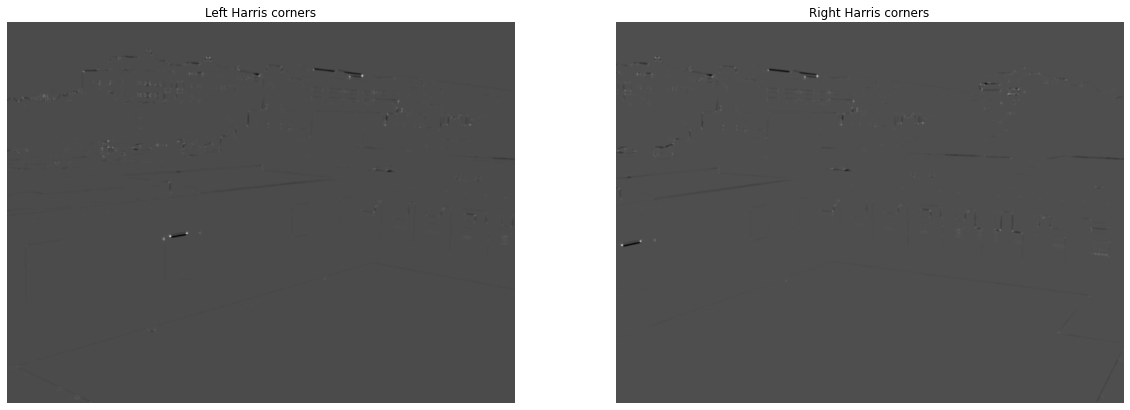

In [6]:
left_harris_corners = cv2.cornerHarris(left_img, 3, 9, .03)
right_harris_corners = cv2.cornerHarris(right_img, 3, 9, .03)

plt.figure(figsize=(20, 12))
plt.subplot(121)
plt.title("Left Harris corners")
plt.imshow(left_harris_corners, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title("Right Harris corners")
plt.imshow(right_harris_corners, cmap='gray')
plt.axis('off')

print(f"Left Image keypoints: {len(left_harris_corners)}, Right Image keypoints: {len(right_harris_corners)}")

Left Image keypoints: 193, Right Image keypoints: 178


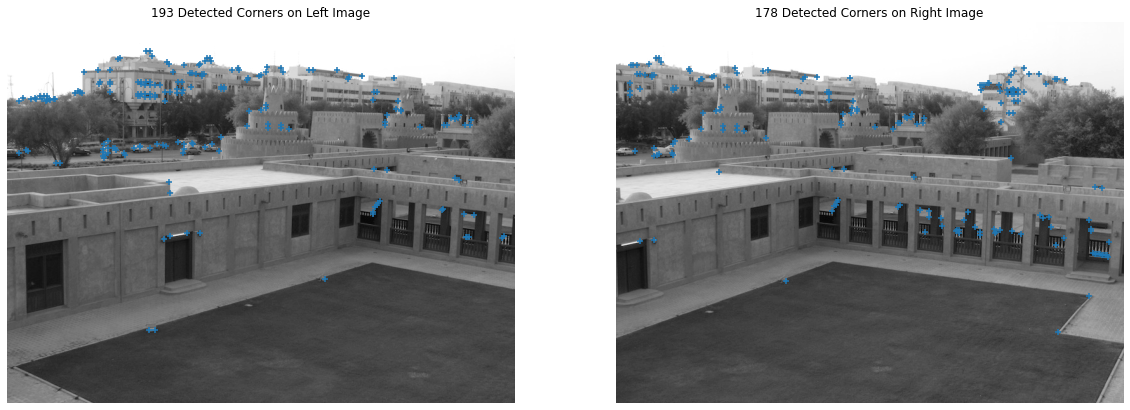

In [7]:
# get corner peaks
left_keypoints = skfeature.corner_peaks(left_harris_corners, threshold_rel=0.05, exclude_border=PATCH_SIZE//2)
right_keypoints = skfeature.corner_peaks(right_harris_corners, threshold_rel=0.05, exclude_border=PATCH_SIZE//2)

# plotting

plt.figure(figsize=(20, 12))

plt.subplot(121)
plt.title(f'{len(left_keypoints)} Detected Corners on Left Image')
plt.imshow(left_img, cmap='gray')
plt.scatter(left_keypoints[:,1], left_keypoints[:,0], marker='+')
plt.axis('off')

plt.subplot(122)
plt.title(f'{len(right_keypoints)} Detected Corners on Right Image')
plt.imshow(right_img, cmap='gray')
plt.scatter(right_keypoints[:,1], right_keypoints[:,0], marker='+')
plt.axis('off')

print(f"Left Image keypoints: {len(left_keypoints)}, Right Image keypoints: {len(right_keypoints)}")

In [8]:
# normalization of patch descriptor

def normalization(keypoint_desc):
  return (keypoint_desc / np.linalg.norm(keypoint_desc)).flatten()

In [9]:
# keypoint description by creating fixed size patches around the keypoint

def describe_keypoints(image, keypoints, patch_size=PATCH_SIZE):
  
  image.astype(np.float32)
  kp_descriptors = []
  
  for kp in keypoints:
    y, x = kp

    patch = image[y-(patch_size//2):y+((patch_size+1)//2), x-(patch_size//2):x+((patch_size+1)//2)]
    
    kp_descriptors.append(normalization(patch))

  return np.array(kp_descriptors)

In [10]:
# get keypoint indicides that match based on euclidean distance

def euclidean_get_matches(desc_1, desc_2, thresh):
  
  distances = cdist(desc_1, desc_2)

  left_desc_index, right_desc_index = [], []
  
  for i in range(len(distances)):
    if distances[i].min() < thresh:
      left_desc_index.append(i)
      right_desc_index.append(distances[i].argmin())

  return left_desc_index, right_desc_index, distances

In [11]:
# get keypoint indicides that match based on correlation distance

def correlation_get_matches(desc_1, desc_2, thresh):
  
  distances = np.zeros((len(desc_1), len(desc_2)))
  
  for i in range(len(desc_1)):
    for j in range(len(desc_2)):
      distances[i][j] = np.correlate(desc_1[i], desc_2[j])
  
  distances = distances / distances.max()
  distances = 1 - distances
    
  left_desc_index, right_desc_index = [], []
  
  for i in range(distances.shape[0]):
    if distances[i].min() < thresh:
      left_desc_index.append(i)
      right_desc_index.append(distances[i].argmin())

  return left_desc_index, right_desc_index, distances

In [12]:
left_desc = describe_keypoints(left_img, left_keypoints)
right_desc = describe_keypoints(right_img, right_keypoints)

In [13]:
left_desc.shape

(193, 1024)

In [14]:
right_desc.shape

(178, 1024)

In [15]:
index1, index2, distances = euclidean_get_matches(left_desc, right_desc, 0.15)
# index1, index2, distances = correlation_get_matches(left_desc, right_desc, 0.003)
print(f"Matched features: {len(index1)}")

Matched features: 77


## Sensitivity analysis on distance threshold

In [16]:
threshold = [0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

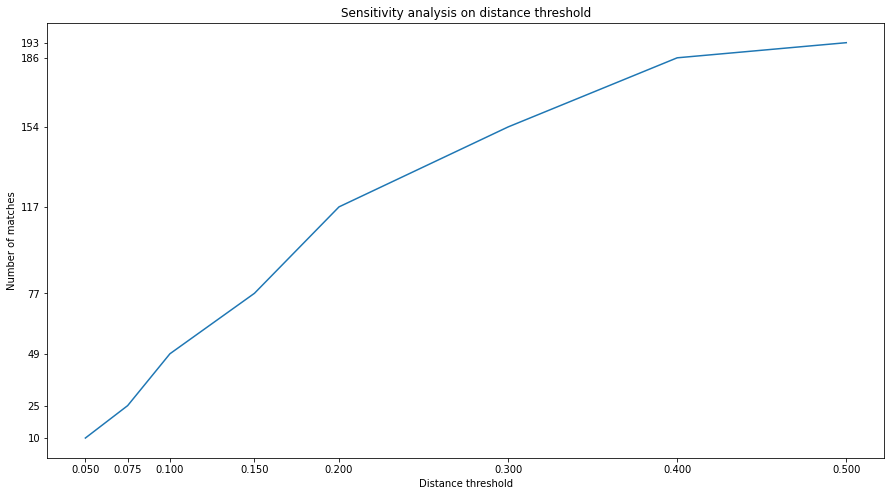

In [17]:
nr_matches = []
for t in threshold:
  i, _, _ = euclidean_get_matches(left_desc, right_desc, t)

  nr_matches.append(len(i))

plt.figure(figsize=(15, 8))
plt.title("Sensitivity analysis on distance threshold")
plt.ylabel("Number of matches")
plt.xlabel("Distance threshold")
plt.yticks(nr_matches)
plt.xticks(threshold)
plt.plot(threshold, nr_matches);

In [18]:
left_matches, right_matches = left_keypoints[index1], right_keypoints[index2]

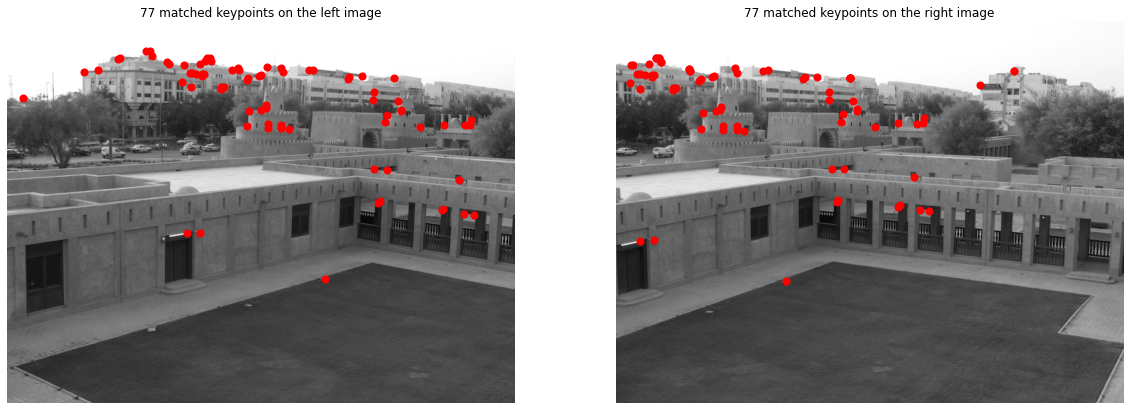

In [19]:
# Display detected corners
plt.figure(figsize=(20, 12))

plt.subplot(121)
plt.title(f'{len(left_matches)} matched keypoints on the left image')
plt.imshow(left_img, cmap='gray')
plt.scatter(left_matches[:,1], left_matches[:,0], marker='o', s=50, color='r')
plt.axis('off')

plt.subplot(122)
plt.title(f'{len(left_matches)} matched keypoints on the right image')
plt.imshow(right_img, cmap='gray')
plt.scatter(right_matches[:,1], right_matches[:,0], marker='o', s=50, color='r')
plt.axis('off');

# RANSAC

http://6.869.csail.mit.edu/fa12/lectures/lecture13ransac/lecture13ransac.pdf

RANSAC loop:
- Select four feature pairs (at random)
- Compute homography H (exact)
- Compute inliers where $ ||pi', H pi|| < \epsilon $
- Keep largest set of inliers
- Re-compute least-squares H estimate using all of the inliers 

In [20]:
matches = np.array([index1, index2])
matches

array([[  1,   2,   3,   8,   9,  10,  11,  12,  13,  15,  16,  17,  19,
         20,  25,  26,  29,  33,  39,  41,  43,  45,  51,  53,  58,  59,
         62,  63,  64,  74,  79,  83,  88,  90,  92,  94,  96,  97, 103,
        104, 105, 106, 107, 110, 112, 115, 117, 118, 121, 122, 123, 125,
        128, 131, 132, 133, 134, 144, 150, 154, 158, 160, 161, 162, 163,
        164, 165, 166, 168, 171, 172, 174, 178, 181, 184, 185, 189],
       [  0,   1,   2,  10,   3,  17,   6,  57,   8,   7,  14,  26,  11,
         18,  16,  25, 113,  41,  30, 136,  19,  39,  10,  61,  40,  43,
         75,  50,  71,  51,  52, 136,  78,  99,  42,  82,  62,  92, 100,
        105,  88,  84, 106, 117, 136,  93,  98,  70,  87,  86, 116,  99,
        162, 114, 118,  41,   8, 104, 154, 129, 133, 128, 170, 134, 171,
        132,  71, 125, 176, 157, 136, 155, 164, 136, 120,  92, 119]])

In [21]:
# Functions to convert points to homogeneous coordinates and back
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:,:-1]

In [22]:
'''
ransac implementation
@params
  - keypoints1 - left image keypoints
  - keypoints2 - right image keypoints
  - matches - match indices on both images
'''

# reference
# https://en.wikipedia.org/wiki/Random_sample_consensus

def RANSAC(keypoints1, keypoints2, matches, n_iters=200, sample_size=3, threshold=20, verbose=False):
  
  N = matches.shape[0]
  n_samples = sample_size
  matched1, matched2 = pad(keypoints1[matches[:, 0]]), pad(keypoints2[matches[:, 1]])
  max_inliers = np.zeros(N, dtype='uint8')
  n_inliers = 0
  H = None
  errors, min_error = [], 0

  for it in range(n_iters):
    n_inliers, n_outliers = 0, 0
    current_inliers = np.zeros(N, dtype='uint8')
    
    random_indices = random.sample(range(matched1.shape[0]), n_samples)
    random_matched1, random_matched2 = [matched1[i] for i in random_indices], [matched2[i] for i in random_indices]

    affine_transformation_matrix, _, _, _ = np.linalg.lstsq(random_matched2, random_matched1)

    for i in range(len(matched1)):
      error = np.sum((matched1[i] - np.matmul(matched2[i],affine_transformation_matrix))**2)
      if  error < threshold: # residuals
          current_inliers[i] = 1
          n_inliers += 1

    if n_inliers > np.sum(max_inliers):
      max_inliers = np.copy(current_inliers)
      H = affine_transformation_matrix
      min_error = error
      
    errors.append(min_error)
    
    if verbose:
      print(f"Iteration {it}")
      print(f"Number of inliers {n_inliers}")

  affine_transformation_matrix, _, _, _ = np.linalg.lstsq(keypoints2[matches[max_inliers][:,1]],
                                                          keypoints1[matches[max_inliers][:,0]])

  return H, errors, np.array([matches[i] for i in range(np.array(max_inliers).shape[0]) if max_inliers[i]==1])

## RANSAC sensitivity analysis

### Number of iterations

In [23]:
nr_iterations = list(range(100, 600, 100))
nr_iterations

[100, 200, 300, 400, 500]

### Threshold

In [24]:
threshold = [0.5, 1.0, 2.5, 5, 10, 20]
threshold

[0.5, 1.0, 2.5, 5, 10, 20]

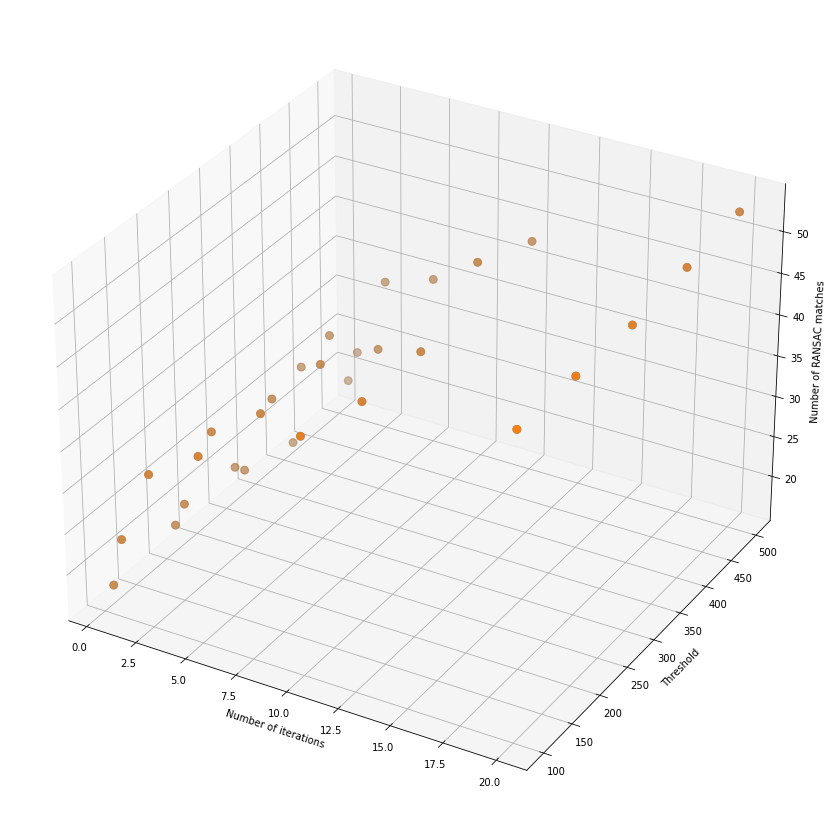

In [25]:
nr_matches = []
for nr in nr_iterations:
  for t in threshold:
    _, _, robust_matches = RANSAC(left_keypoints, right_keypoints, matches.T, nr, 3, t)
    
    nr_matches.append(len(robust_matches))

# plotting

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')

for m, zlow, zhigh in [('o', -50, -25), ('o', -30, -5)]:
    xs = threshold * len(nr_iterations)
    ys = nr_iterations * len(threshold)
    zs = nr_matches
    ax.scatter(xs, ys, zs, marker=m, s=60)
  
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Threshold')
ax.set_zlabel('Number of RANSAC matches')

plt.show();

### Number of samples

In [26]:
nr_samples = [3, 5, 9, 15, 20, 30]

In [ ]:
# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py

nr_matches = []
for nr in nr_samples:
  _, _, ransac_matches = RANSAC(left_keypoints, right_keypoints, matches.T, 100, 3, 0.5)

  nr_matches.append(len(ransac_matches))

# nr_matches = []
  
plt.figure(figsize=(15, 8))
plt.title("Sensitivity analysis on distance threshold")
plt.ylabel("Number of matches")
plt.xlabel("Number of samples")
plt.yticks(nr_matches)
plt.xticks(nr_samples)
plt.plot(nr_samples, nr_matches);

## Running RANSAC

In [ ]:
matches_before_ransac = len(matches.T)
matches_before_ransac

In [ ]:
H, errors, ransac_matches = RANSAC(left_keypoints, right_keypoints, matches.T, 300, 9, 0.5, verbose=True)

In [ ]:
plt.title("Minimum error (least squared) in 300 iterations")
plt.plot(errors);

In [ ]:
robust_left_matches, robust_right_matches = left_keypoints[ransac_matches[:, 0]], right_keypoints[ransac_matches[:, 1]]

In [ ]:
plt.figure(figsize=(20, 12))

plt.subplot(121)
plt.title(f'{len(robust_left_matches)} matched keypoints on the left image')
plt.imshow(left_img, cmap='gray')
plt.scatter(robust_left_matches[:,1], robust_left_matches[:,0], marker='o', s=50, color='r')
plt.axis('off')

plt.subplot(122)
plt.title(f'{len(robust_right_matches)} matched keypoints on the right image')
plt.imshow(right_img, cmap='gray')
plt.scatter(robust_right_matches[:,1], robust_right_matches[:,0], marker='o', s=50, color='r')
plt.savefig('results/matches.jpg')
plt.axis('off');

## Stitching

In [ ]:
# reference:
# https://stackoverflow.com/questions/44457064/displaying-stitched-images-together-without-cutoff-using-warpaffine

In [ ]:
# get warp corners in the first image

def get_warp_corners(base_img, transforms):
    h, w = base_img.shape
    H = transforms
    corners = np.array([[0, 0], [h, 0], [0, w], [h, w]])
    
    all_corners = [corners]
    
    warped_corners = corners.dot(H[:2,:2]) + H[2,:2]
    
    all_corners.append(warped_corners)
    all_corners = np.vstack(all_corners)

    corner_min, corner_max = np.min(all_corners, axis=0), np.max(all_corners, axis=0)
    
    output_shape = (corner_max - corner_min).astype(int)
    
    offset = corner_min

    return output_shape, offset

# perform warping of the output image based on affine transformation matrix  

def warp_image(img, H, output_shape, offset):

    H_inv = np.linalg.inv(H)
    
    # parameters
    m = H_inv.T[:2,:2]
    b = H_inv.T[:2,2]
    
    img_warped = affine_transform(img.astype(np.float32), m, b+offset, output_shape, cval=-1)

    return img_warped

In [ ]:
output_shape, offset = get_warp_corners(left_img, H)

left_warp = warp_image(left_img, np.eye(3), output_shape, offset)
left_mask = (left_warp != -1)

# make black background
left_warp[~left_mask] = 0

right_warp = warp_image(right_img, H, output_shape, offset)
right_mask = (right_warp != -1)

# make black background
right_warp[~right_mask] = 0

plt.figure(figsize=(20, 12))
plt.subplot(1,2,1)
plt.imshow(left_warp, cmap='gray')
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(right_warp, cmap='gray')
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

In [ ]:
merged = left_warp + right_warp

overlap = (left_mask * 1.0 + right_mask)

# overlap masks
stitched = merged / np.maximum(overlap, 1)

plt.figure(figsize=(20, 12))

plt.title("Stitched image")
plt.axis('off')

plt.imsave("results/stitched.jpg", stitched, cmap='gray')
plt.imshow(stitched, cmap='gray')
plt.show()